In [34]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [13]:
df = pd.read_csv("/content/renewable_energy.csv", sep=",", header=0)

In [14]:
df.drop(columns=['FREQUENCY', 'Flag Codes'], inplace=True)

In [15]:
df.head()


,LOCATION,INDICATOR,SUBJECT,MEASURE,TIME,Value
0,AUS,RENEWABLE,TOT,KTOE,1960,4436.932
1,AUS,RENEWABLE,TOT,KTOE,1961,4490.510
2,AUS,RENEWABLE,TOT,KTOE,1962,4407.097
3,AUS,RENEWABLE,TOT,KTOE,1963,4628.738
4,AUS,RENEWABLE,TOT,KTOE,1964,4497.396


In [16]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15904 entries, 0 to 15903
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LOCATION   15904 non-null  object 
 1   INDICATOR  15904 non-null  object 
 2   SUBJECT    15904 non-null  object 
 3   MEASURE    15904 non-null  object 
 4   TIME       15904 non-null  int64  
 5   Value      12017 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 745.6+ KB
None
               TIME         Value
count  15904.000000  1.201700e+04
mean    1987.500000  1.322108e+04
std       16.163738  9.203502e+04
min     1960.000000  0.000000e+00
25%     1973.750000  9.580000e+00
50%     1987.500000  7.486000e+01
75%     2001.250000  1.816018e+03
max     2015.000000  1.894019e+06


In [17]:
for col in df.columns:
    print(f"{col}: {df[col].unique()[:5]}")  # Primeiros 5 valores únicos

LOCATION: ['AUS' 'AUT' 'BEL' 'CAN' 'CZE']
INDICATOR: ['RENEWABLE']
SUBJECT: ['TOT']
MEASURE: ['KTOE' 'PC_PRYENRGSUPPLY']
TIME: [1960 1961 1962 1963 1964]
Value: [4436.932 4490.51  4407.097 4628.738 4497.396]


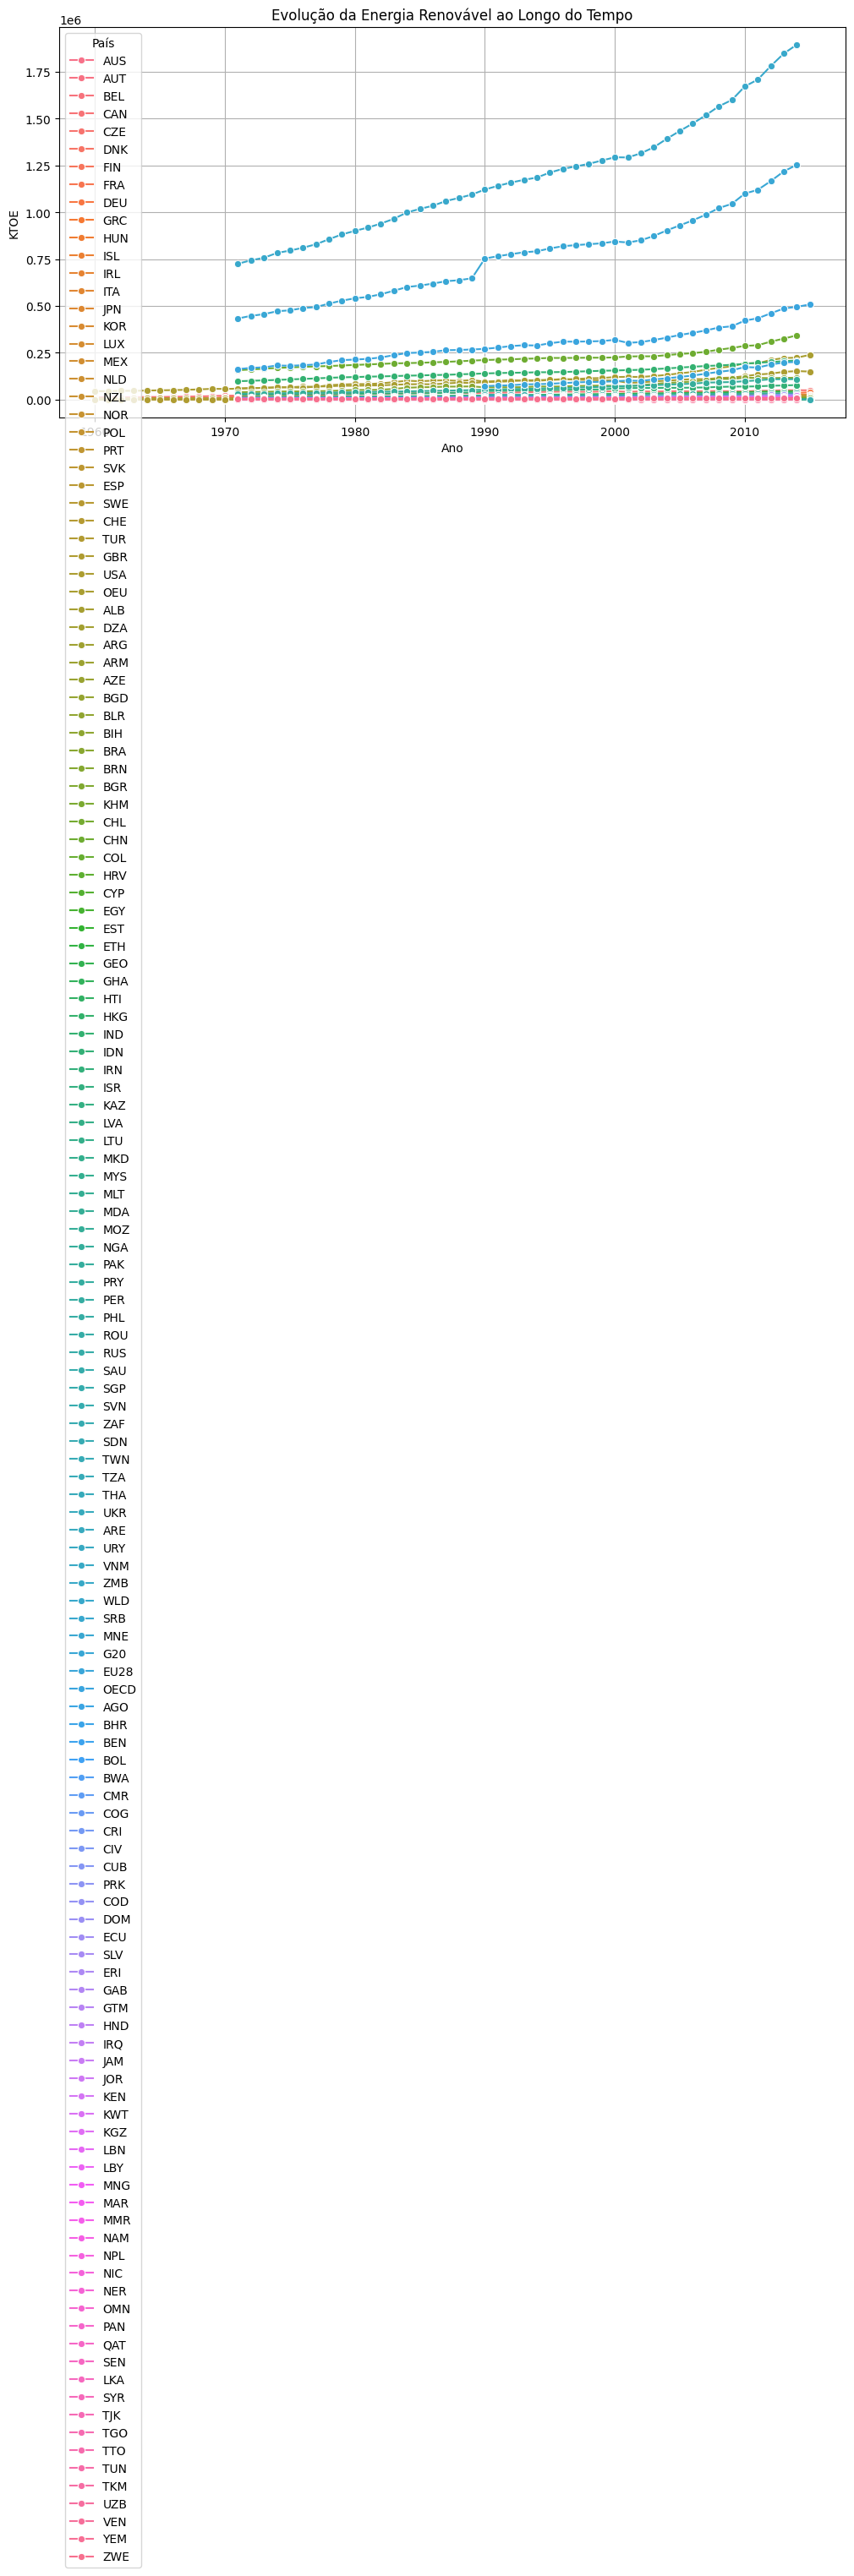

In [18]:
df_filtered = df[df['MEASURE'] == 'KTOE']

# Plotar tendências ao longo do tempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='TIME', y='Value', hue='LOCATION', marker='o')
plt.title("Evolução da Energia Renovável ao Longo do Tempo")
plt.xlabel("Ano")
plt.ylabel("KTOE")
plt.legend(title='País')
plt.grid(True)
plt.show()

<ipython-input-19-9e3211b0c9cc>:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_filtered['GrowthRate'] = df_filtered.groupby('LOCATION')['Value'].pct_change() * 100
<ipython-input-19-9e3211b0c9cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['GrowthRate'] = df_filtered.groupby('LOCATION')['Value'].pct_change() * 100


    LOCATION  GrowthRate
0        AGO    1.954589
1        ALB    1.777204
2        ARE         inf
3        ARG    3.195437
4        ARM    4.330756
..       ...         ...
137      WLD    2.210764
138      YEM    1.957034
139      ZAF    2.838608
140      ZMB    3.271889
141      ZWE    2.009826

[142 rows x 2 columns]


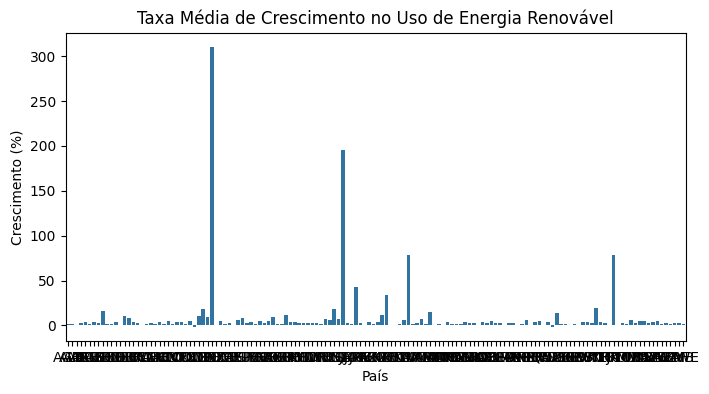

In [19]:
#Calcular taxa de crescimento anual para cada país
df_filtered['GrowthRate'] = df_filtered.groupby('LOCATION')['Value'].pct_change() * 100

avg_growth = df_filtered.groupby('LOCATION')['GrowthRate'].mean().reset_index()
print(avg_growth)

plt.figure(figsize=(8, 4))
sns.barplot(data=avg_growth, x='LOCATION', y='GrowthRate')
plt.title("Taxa Média de Crescimento no Uso de Energia Renovável")
plt.xlabel("País")
plt.ylabel("Crescimento (%)")
plt.show()


In [26]:
# Criar a coluna 'GrowthRate'
df['GrowthRate'] = df.groupby('LOCATION')['Value'].pct_change() * 100

# Criar a coluna 'Category'
df['Category'] = pd.cut(
    df['GrowthRate'],
    bins=[-float('inf'), -1, 1, float('inf')],
    labels=['Declínio', 'Estável', 'Crescimento']
)

In [27]:
# Verificar se a coluna foi criada corretamente
print(df[['GrowthRate', 'Category']].head())

   GrowthRate     Category
1         NaN          NaN
2   -1.857540     Declínio
3    5.029184  Crescimento
4   -2.837534     Declínio
5    4.863592  Crescimento


In [35]:
# Remover valores ausentes gerados por pct_change
df.dropna(inplace=True)

# Transformar variáveis categóricas em numéricas, exceto 'Category'
df_encoded = pd.get_dummies(df.drop(columns=['Category']), drop_first=True)

# Adicionar a coluna 'Category' de volta ao DataFrame codificado
df_encoded['Category'] = df['Category']

# Separar variáveis dependentes e independentes
X = df_encoded.drop(columns=['Category'])
y = df_encoded['Category']

X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

In [36]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de classificação
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

In [37]:
# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
print(classification_report(y_test, y_pred))

Accuracy: 100.00%
              precision    recall  f1-score   support

 Crescimento       1.00      1.00      1.00      1164
    Declínio       1.00      1.00      1.00       739
     Estável       1.00      1.00      1.00       351

    accuracy                           1.00      2254
   macro avg       1.00      1.00      1.00      2254
weighted avg       1.00      1.00      1.00      2254

